## Trayendo datos

In [2]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2017-07-01 00:00:00"),
                  end=string2ts("2018-03-01 00:00:00"),
                  period=3600*4)
per = 0.85


## Parámetros vía stockstacks

In [3]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

/home/Dsiervo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Creando estrategia ideal y separando en train y test 

In [4]:
from mldata import ml_data
from orders import orders
from profit import profit

df["ml_data"] = ml_data(df["close"],la=10, pl=False)

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"],"ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"],"kdjk":stock["kdjk"],
                          "kdjd":stock["kdjd"],"kdjj":stock["kdjj"], "dma":stock["dma"], "trix":stock["trix"],
                          "vr":stock["vr"]})

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='bfill', inplace=True)

train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]

train.tail()

Retorno de estrategia ideal: 42805.58138640792


,cci,close,dma,ideal_w,kdjd,kdjj,kdjk,macd,macds,price,pricew,rsi,trix,volatility,volumen,vr,wr
date,,,,,,,,,,,,,,,,,
2018-01-22 20:00:00,53.594940,0.000124,-0.000005,1.0,36.514639,76.925898,49.985059,-0.000003,-0.000002,0.000124,0.000118,52.188082,-0.371616,True,1193.332722,36.812044,16.469120
2018-01-23 00:00:00,114.901357,0.000122,-0.000005,1.0,44.491601,92.353375,60.445526,-0.000002,-0.000002,0.000122,0.000122,50.230005,-0.355745,False,1108.483996,40.238765,18.633540
2018-01-23 04:00:00,57.322808,0.000120,-0.000004,1.0,50.316779,85.267846,61.967134,-0.000002,-0.000002,0.000120,0.000120,47.393459,-0.335701,True,542.760002,45.259988,34.989648
2018-01-23 08:00:00,54.807124,0.000120,-0.000004,1.0,54.630383,80.512011,63.257593,-0.000002,-0.000002,0.000120,0.000120,47.554950,-0.312800,False,558.331852,35.501154,34.161491
2018-01-23 12:00:00,176.899243,0.000125,-0.000003,1.0,59.638420,89.686640,69.654493,-0.000001,-0.000002,0.000125,0.000124,54.137682,-0.273059,True,1068.716270,45.374908,17.551705


## Importando modelos de clasificación

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

features = ["price","rsi","cci","macds","macd","wr","trix","vr"]

X, y = data[features], data["ideal_w"]

## Validación cruzada XGBoost 

Se obtienen los valores:
* n_estimators = 9
* learning_rate = 0.75
* gamma = 12

### base_score

In [6]:
# tuneado de base_score

params = np.linspace(0.01, 0.99, 10)
#params = np.logspace(-10, 0, 10)
xgb = XGBClassifier()

scores = list()
scores_std = list()

for bs in params:
    xgb.base_score = bs
    
    this_scores = cross_val_score(xgb, X, y, n_jobs=-1);
    
    # calculando promedio y std de las validaciones cruzadas
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
    

/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

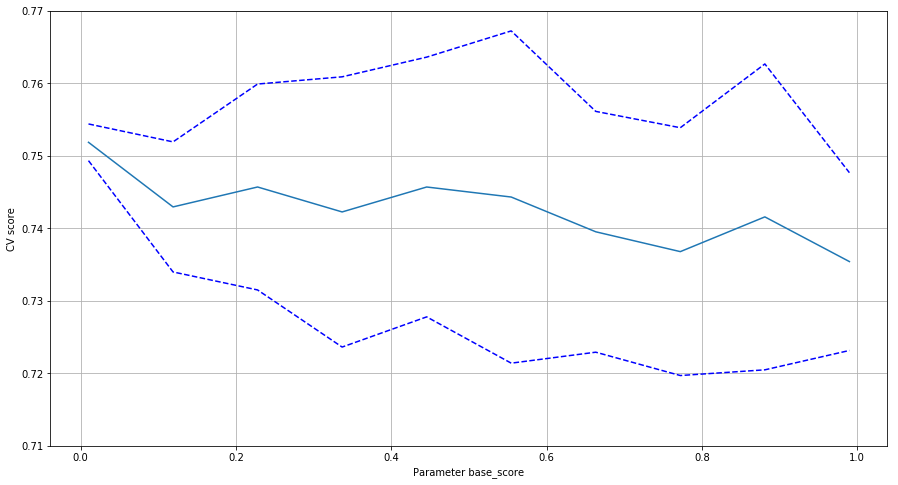

In [7]:
plt.plot(params, scores)
plt.plot(params, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(params, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter base_score')
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### n_estimators

/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

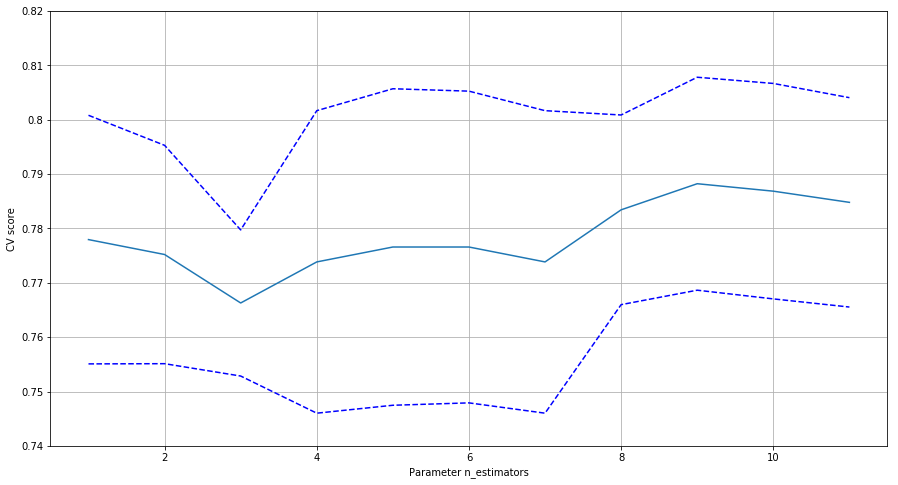

In [8]:
parameter = "n_estimators"
params = range(1,12)
#params = np.logspace(-10, 0, 10)
xgb = XGBClassifier()

scores = list()
scores_std = list()

for bs in params:
    xgb.n_estimators = bs
    
    this_scores = cross_val_score(xgb, X, y, n_jobs=-1)
    
    # calculando promedio y std de las validaciones cruzadas
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.plot(params, scores)
plt.plot(params, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(params, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### learning_rate

/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

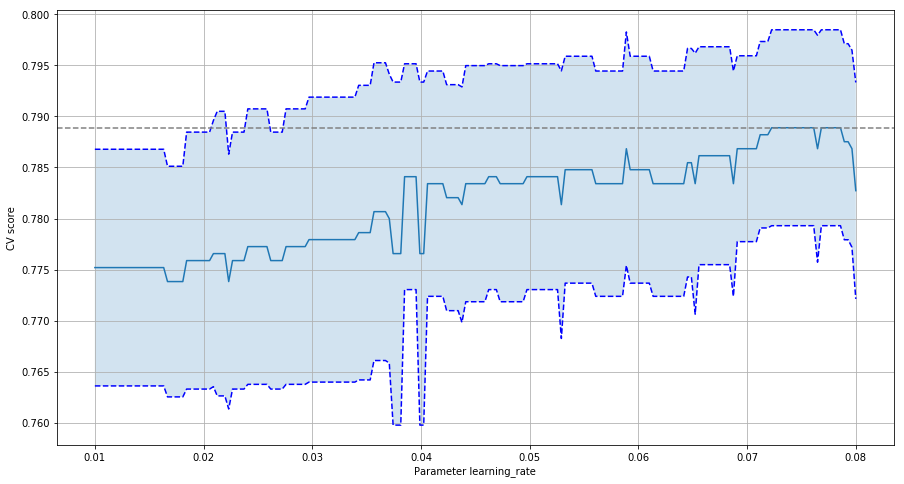

In [9]:
parameter = "learning_rate"
alphas = np.linspace(0.01, 0.08, 200)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### max_depth

/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

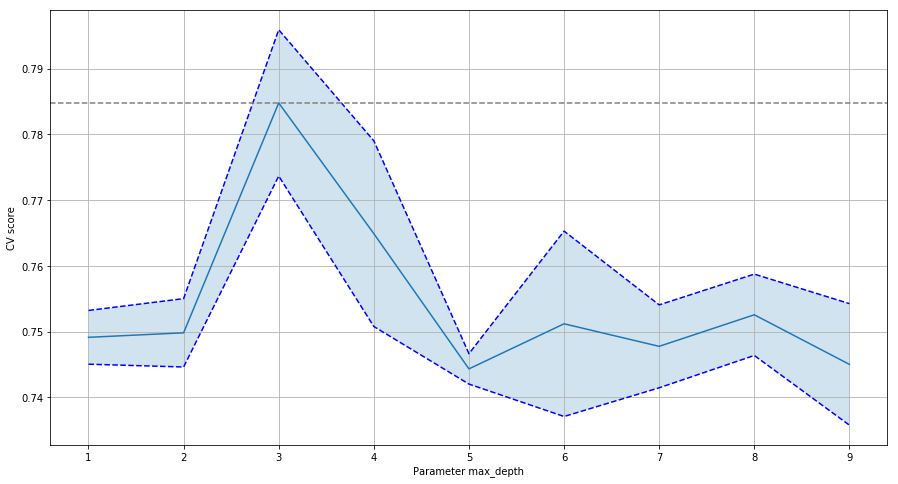

In [10]:
parameter = "max_depth"
alphas = range(1,10)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### gamma

/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

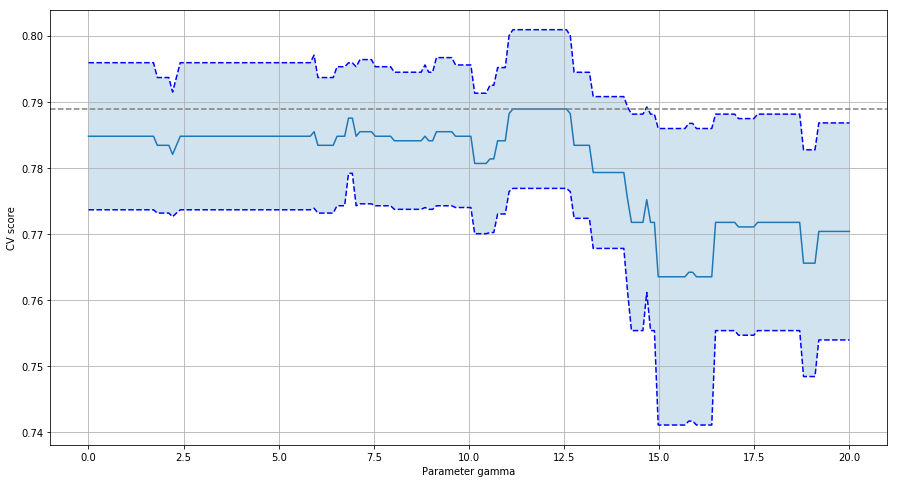

In [11]:
parameter = "gamma"
alphas = np.linspace(0, 20, 20)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## DecisionTreeClassifier

### max_depth

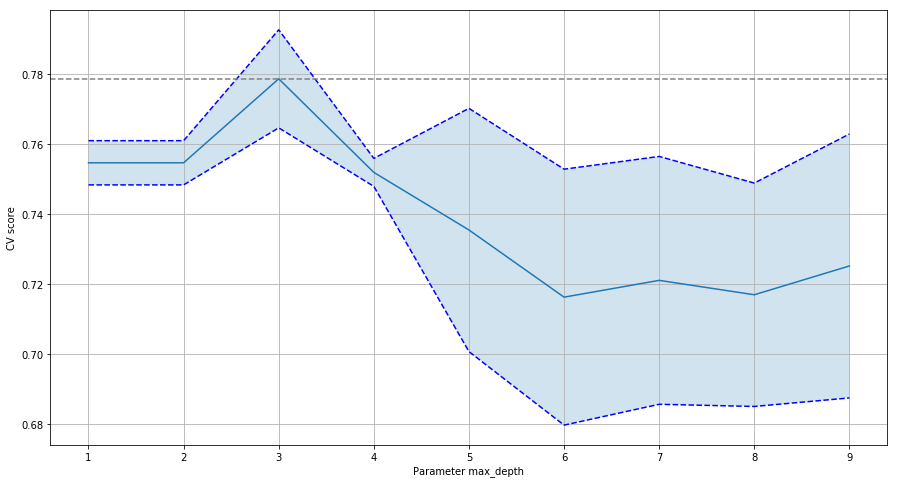

In [15]:
decision_tree = DecisionTreeClassifier()

parameter = "max_depth"
alphas = range(1,10)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(decision_tree, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_split

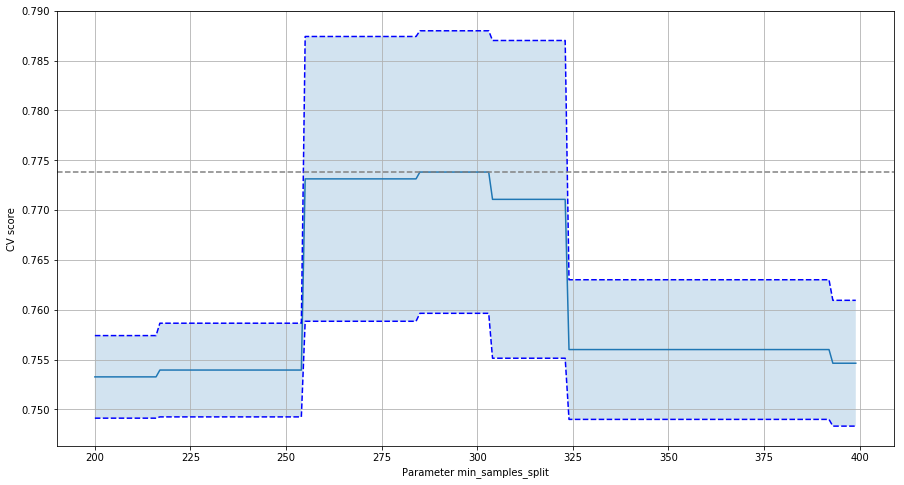

In [20]:
parameter = "min_samples_split"
alphas = range(200,400)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(decision_tree, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_leaf

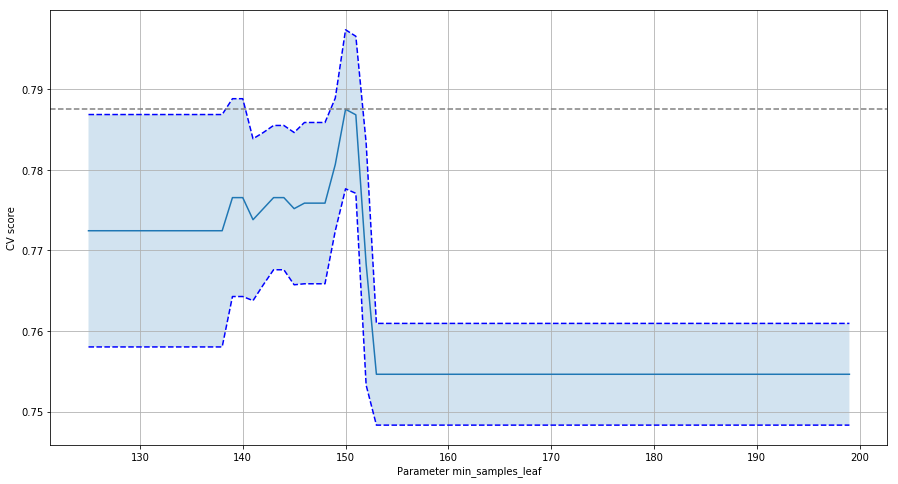

In [25]:
parameter = "min_samples_leaf"
alphas = range(125,200)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(decision_tree, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## random forest

### n_estimators

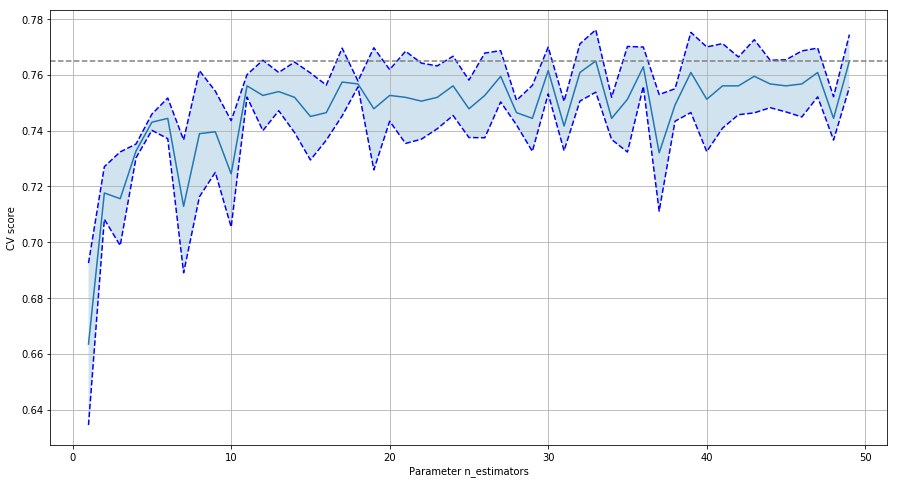

In [36]:
random_forest = RandomForestClassifier()

parameter = "n_estimators"
alphas = range(1,50)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### max_depth

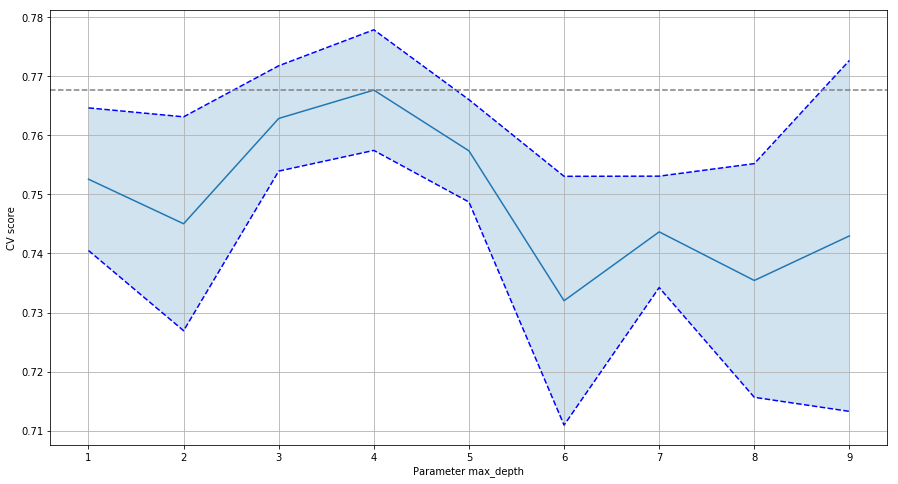

In [38]:
parameter = "max_depth"
alphas = range(1,10)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_split

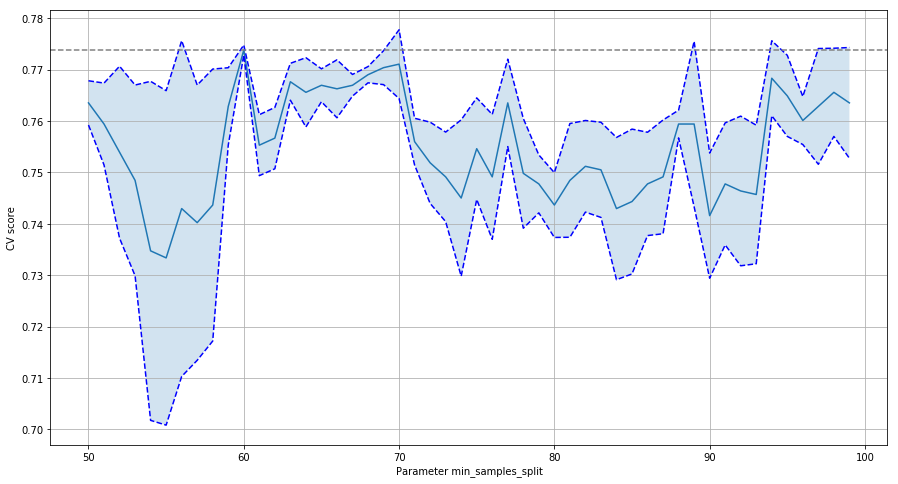

In [41]:
parameter = "min_samples_split"
alphas = range(50,100)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_leaf

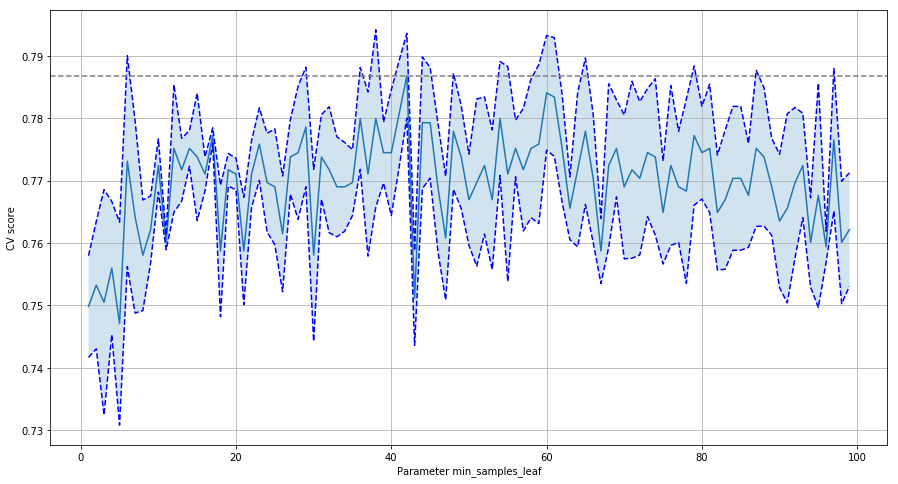

In [43]:
parameter = "min_samples_leaf"
alphas = range(1,100)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## Regresion logistica

### C

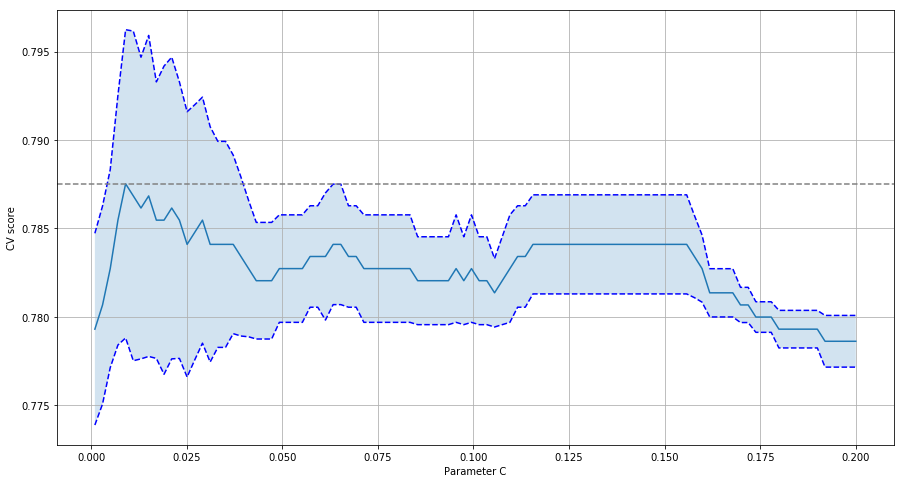

In [54]:
logreg = LogisticRegression()

parameter = "C"
alphas = np.linspace(0.001,0.2,100)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(logreg, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## MPLC

### alpha

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] alpha=0.0001 ....................................................
[CV] alpha=0.0001 ....................................................
[CV] alpha=0.0001 ....................................................
[CV] alpha=0.0021387755102040816 .....................................
[CV] alpha=0.0021387755102040816 .....................................
[CV] alpha=0.004177551020408164 ......................................
[CV] alpha=0.004177551020408164 ......................................
[CV] alpha=0.0021387755102040816 .....................................
[CV] alpha=0.004177551020408164 ......................................
[CV] alpha=0.006216326530612245 ......................................
[CV] alpha=0.006216326530612245 ......................................
[CV] alpha=0.006216326530612245 ......................................
[CV] alpha=0.008255102040816326 ......................................
[CV] alpha=0.00

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s


[CV] . alpha=0.014371428571428571, score=0.751028806584, total=   0.6s
[CV] alpha=0.016410204081632653 ......................................
[CV] .. alpha=0.01233265306122449, score=0.746913580247, total=   1.4s
[CV] ............... alpha=0.0001, score=0.767967145791, total=   4.0s
[CV] alpha=0.018448979591836733 ......................................
[CV] alpha=0.018448979591836733 ......................................
[CV] . alpha=0.004177551020408164, score=0.767967145791, total=   4.4s
[CV] alpha=0.018448979591836733 ......................................
[CV] . alpha=0.006216326530612245, score=0.767967145791, total=   4.3s
[CV] alpha=0.020487755102040817 ......................................
[CV] ... alpha=0.008255102040816326, score=0.7659137577, total=   4.1s
[CV] alpha=0.020487755102040817 ......................................
[CV] . alpha=0.006216326530612245, score=0.763374485597, total=   4.3s
[CV] alpha=0.020487755102040817 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.9s


[CV] . alpha=0.016410204081632653, score=0.751540041068, total=   1.8s
[CV] alpha=0.02456530612244898 .......................................
[CV] ... alpha=0.0225265306122449, score=0.775720164609, total=   0.4s
[CV] alpha=0.02456530612244898 .......................................
[CV] ... alpha=0.010293877551020408, score=0.7659137577, total=   5.1s
[CV] alpha=0.02660408163265306 .......................................
[CV] . alpha=0.016410204081632653, score=0.755144032922, total=   2.6s
[CV] alpha=0.02660408163265306 .......................................
[CV] . alpha=0.016410204081632653, score=0.769547325103, total=   2.2s
[CV] .. alpha=0.02456530612244898, score=0.788065843621, total=   0.7s
[CV] alpha=0.02660408163265306 .......................................
[CV] alpha=0.028642857142857144 ......................................
[CV] . alpha=0.018448979591836733, score=0.728952772074, total=   2.2s
[CV] alpha=0.028642857142857144 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    7.2s


[CV] .. alpha=0.02456530612244898, score=0.751028806584, total=   2.1s
[CV] alpha=0.030681632653061227 ......................................
[CV] . alpha=0.014371428571428571, score=0.743326488706, total=   4.5s
[CV] alpha=0.030681632653061227 ......................................
[CV] .. alpha=0.02456530612244898, score=0.737166324435, total=   2.7s
[CV] ... alpha=0.0225265306122449, score=0.746913580247, total=   2.6s
[CV] alpha=0.03272040816326531 .......................................
[CV] alpha=0.030681632653061227 ......................................
[CV] .. alpha=0.014371428571428571, score=0.72633744856, total=   4.5s
[CV] . alpha=0.018448979591836733, score=0.753086419753, total=   3.9s
[CV] alpha=0.03272040816326531 .......................................
[CV] alpha=0.03272040816326531 .......................................
[CV] . alpha=0.020487755102040817, score=0.755144032922, total=   3.6s
[CV] alpha=0.03475918367346939 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.2s


[CV] .. alpha=0.03475918367346939, score=0.800411522634, total=   0.6s
[CV] ... alpha=0.020487755102040817, score=0.7659137577, total=   4.8s
[CV] alpha=0.03883673469387756 .......................................
[CV] alpha=0.03883673469387756 .......................................
[CV] .. alpha=0.02660408163265306, score=0.730452674897, total=   3.5s
[CV] alpha=0.03883673469387756 .......................................
[CV] .... alpha=0.02660408163265306, score=0.7659137577, total=   3.9s
[CV] alpha=0.04087551020408164 .......................................
[CV] ... alpha=0.0225265306122449, score=0.745379876797, total=   5.0s
[CV] alpha=0.04087551020408164 .......................................
[CV] .. alpha=0.03272040816326531, score=0.748971193416, total=   2.0s
[CV] alpha=0.04087551020408164 .......................................
[CV] .. alpha=0.04087551020408164, score=0.757700205339, total=   0.4s
[CV] alpha=0.04291428571428572 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.9s


[CV] alpha=0.046991836734693884 ......................................
[CV] .. alpha=0.03883673469387756, score=0.757700205339, total=   1.6s
[CV] alpha=0.046991836734693884 ......................................
[CV] . alpha=0.030681632653061227, score=0.757700205339, total=   3.9s
[CV] .. alpha=0.04291428571428572, score=0.779835390947, total=   1.0s
[CV] alpha=0.046991836734693884 ......................................
[CV] alpha=0.049030612244897964 ......................................
[CV] . alpha=0.030681632653061227, score=0.746913580247, total=   4.0s
[CV] alpha=0.049030612244897964 ......................................
[CV] .. alpha=0.03883673469387756, score=0.738683127572, total=   2.2s
[CV] . alpha=0.044953061224489804, score=0.761316872428, total=   1.1s
[CV] alpha=0.049030612244897964 ......................................
[CV] alpha=0.051069387755102044 ......................................
[CV] .. alpha=0.03679795918367347, score=0.738683127572, total=   3.0s
[CV] a

[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   13.1s


[CV] . alpha=0.046991836734693884, score=0.733059548255, total=   2.3s
[CV] . alpha=0.044953061224489804, score=0.755144032922, total=   2.6s
[CV] alpha=0.05718571428571429 .......................................
[CV] alpha=0.05718571428571429 .......................................
[CV] .. alpha=0.05514693877551021, score=0.753593429158, total=   0.8s
[CV] .. alpha=0.04291428571428572, score=0.735112936345, total=   3.5s
[CV] . alpha=0.053108163265306124, score=0.800411522634, total=   1.0s
[CV] alpha=0.05718571428571429 .......................................
[CV] alpha=0.05922448979591837 .......................................
[CV] alpha=0.05922448979591837 .......................................
[CV] ... alpha=0.044953061224489804, score=0.7659137577, total=   3.5s
[CV] alpha=0.05922448979591837 .......................................
[CV] .. alpha=0.04087551020408164, score=0.746913580247, total=   4.3s
[CV] alpha=0.06126326530612246 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   15.6s


[CV] .. alpha=0.05718571428571429, score=0.767489711934, total=   2.1s
[CV] .. alpha=0.05922448979591837, score=0.753593429158, total=   1.7s
[CV] alpha=0.0673795918367347 ........................................
[CV] alpha=0.0673795918367347 ........................................
[CV] .. alpha=0.05718571428571429, score=0.755646817248, total=   2.6s
[CV] alpha=0.0673795918367347 ........................................
[CV] ... alpha=0.05922448979591837, score=0.77366255144, total=   1.9s
[CV] alpha=0.06941836734693878 .......................................
[CV] .. alpha=0.06126326530612246, score=0.749486652977, total=   1.9s
[CV] alpha=0.06941836734693878 .......................................
[CV] .. alpha=0.05514693877551021, score=0.765432098765, total=   4.0s
[CV] alpha=0.06941836734693878 .......................................
[CV] .. alpha=0.05922448979591837, score=0.742798353909, total=   3.3s
[CV] alpha=0.07145714285714286 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   18.6s


[CV] ... alpha=0.06126326530612246, score=0.79012345679, total=   3.6s
[CV] alpha=0.07553469387755103 .......................................
[CV] ... alpha=0.0673795918367347, score=0.738683127572, total=   3.0s
[CV] alpha=0.07553469387755103 .......................................
[CV] .. alpha=0.06534081632653062, score=0.749486652977, total=   3.3s
[CV] .. alpha=0.06534081632653062, score=0.744855967078, total=   3.3s
[CV] alpha=0.07757346938775511 .......................................
[CV] alpha=0.07757346938775511 .......................................
[CV] .. alpha=0.07145714285714286, score=0.755646817248, total=   1.7s
[CV] alpha=0.07757346938775511 .......................................
[CV] .. alpha=0.07349591836734694, score=0.775720164609, total=   0.7s
[CV] .. alpha=0.06330204081632654, score=0.707818930041, total=   3.8s
[CV] alpha=0.07961224489795919 .......................................
[CV] alpha=0.07961224489795919 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   21.5s


[CV] .. alpha=0.07553469387755103, score=0.745379876797, total=   3.2s
[CV] alpha=0.08776734693877551 .......................................
[CV] .. alpha=0.08165102040816327, score=0.767489711934, total=   1.6s
[CV] alpha=0.08776734693877551 .......................................
[CV] .. alpha=0.07757346938775511, score=0.748971193416, total=   3.0s
[CV] .. alpha=0.07553469387755103, score=0.765432098765, total=   3.1s
[CV] alpha=0.08776734693877551 .......................................
[CV] alpha=0.0898061224489796 ........................................
[CV] .. alpha=0.07961224489795919, score=0.779835390947, total=   2.8s
[CV] alpha=0.0898061224489796 ........................................
[CV] .. alpha=0.07757346938775511, score=0.759259259259, total=   3.7s
[CV] alpha=0.0898061224489796 ........................................
[CV] .. alpha=0.08165102040816327, score=0.722792607803, total=   3.2s
[CV] alpha=0.09184489795918369 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:   24.8s remaining:    2.8s


[CV] ... alpha=0.0898061224489796, score=0.738683127572, total=   2.1s
[CV] .. alpha=0.09592244897959185, score=0.751028806584, total=   1.3s
[CV] .. alpha=0.09796122448979593, score=0.783950617284, total=   1.0s
[CV] .. alpha=0.09388367346938777, score=0.767489711934, total=   1.8s
[CV] .. alpha=0.08368979591836735, score=0.759259259259, total=   4.4s
[CV] .... alpha=0.09184489795918369, score=0.7659137577, total=   2.3s
[CV] .................. alpha=0.1, score=0.755646817248, total=   0.8s
[CV] .. alpha=0.09184489795918369, score=0.736625514403, total=   2.5s
[CV] .................. alpha=0.1, score=0.763374485597, total=   0.9s
[CV] .. alpha=0.09184489795918369, score=0.742798353909, total=   2.5s
[CV] .. alpha=0.09592244897959185, score=0.746913580247, total=   1.9s
[CV] .. alpha=0.09796122448979593, score=0.757201646091, total=   1.4s
[CV] .. alpha=0.09388367346938777, score=0.736625514403, total=   2.7s
[CV] .................. alpha=0.1, score=0.728395061728, total=   1.4s


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   26.2s finished


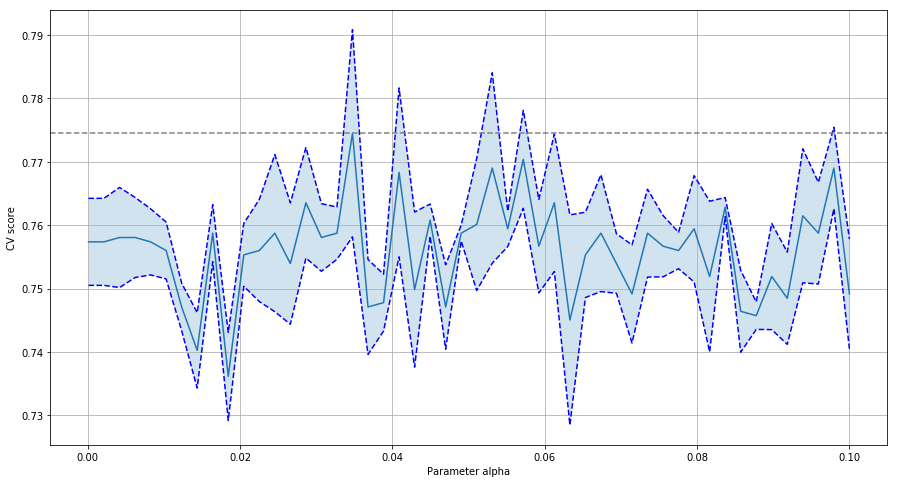

In [61]:
mlpc = MLPClassifier(solver='lbfgs')

parameter = "alpha"
alphas = np.linspace(0.0001,0.1,50)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(mlpc, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, verbose=1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### hidden_layer_sizes 1

Fitting 3 folds for each of 79 candidates, totalling 237 fits
[CV] hidden_layer_sizes=(2, 1) .......................................
[CV] hidden_layer_sizes=(2, 1) .......................................
[CV] hidden_layer_sizes=(2, 1) .......................................
[CV] hidden_layer_sizes=(2, 2) .......................................
[CV] hidden_layer_sizes=(2, 2) .......................................
[CV] ........................ hidden_layer_sizes=(2, 1), total=   0.1s
[CV] hidden_layer_sizes=(2, 2) .......................................
[CV] ........................ hidden_layer_sizes=(2, 1), total=   0.1s
[CV] hidden_layer_sizes=(2, 3) .......................................
[CV] hidden_layer_sizes=(2, 3) .......................................
[CV] hidden_layer_sizes=(2, 3) .......................................
[CV] hidden_layer_sizes=(2, 4) .......................................
[CV] hidden_layer_sizes=(2, 4) .......................................
[CV] hidden_lay

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s


[CV] ........................ hidden_layer_sizes=(2, 7), total=   0.2s
[CV] hidden_layer_sizes=(2, 14) ......................................
[CV] ........................ hidden_layer_sizes=(2, 7), total=   0.3s
[CV] ........................ hidden_layer_sizes=(2, 4), total=   0.3s
[CV] hidden_layer_sizes=(2, 15) ......................................
[CV] hidden_layer_sizes=(2, 15) ......................................
[CV] ....................... hidden_layer_sizes=(2, 11), total=   0.3s
[CV] hidden_layer_sizes=(2, 16) ......................................
[CV] ........................ hidden_layer_sizes=(2, 9), total=   0.5s
[CV] ........................ hidden_layer_sizes=(2, 8), total=   0.6s
[CV] hidden_layer_sizes=(2, 17) ......................................
[CV] hidden_layer_sizes=(2, 17) ......................................
[CV] ........................ hidden_layer_sizes=(2, 8), total=   1.2s
[CV] hidden_layer_sizes=(2, 18) ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   38.0s


[CV] hidden_layer_sizes=(2, 60) ......................................
[CV] ....................... hidden_layer_sizes=(2, 54), total=   5.7s
[CV] hidden_layer_sizes=(2, 60) ......................................
[CV] ....................... hidden_layer_sizes=(2, 55), total=   5.5s
[CV] hidden_layer_sizes=(2, 61) ......................................
[CV] ....................... hidden_layer_sizes=(2, 54), total=   7.2s
[CV] hidden_layer_sizes=(2, 61) ......................................
[CV] ....................... hidden_layer_sizes=(2, 55), total=   5.7s
[CV] ....................... hidden_layer_sizes=(2, 56), total=   5.4s
[CV] hidden_layer_sizes=(2, 61) ......................................
[CV] hidden_layer_sizes=(2, 62) ......................................
[CV] ....................... hidden_layer_sizes=(2, 56), total=   6.2s
[CV] hidden_layer_sizes=(2, 62) ......................................
[CV] ....................... hidden_layer_sizes=(2, 58), total=   5.8s
[CV] h

[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:  1.1min finished


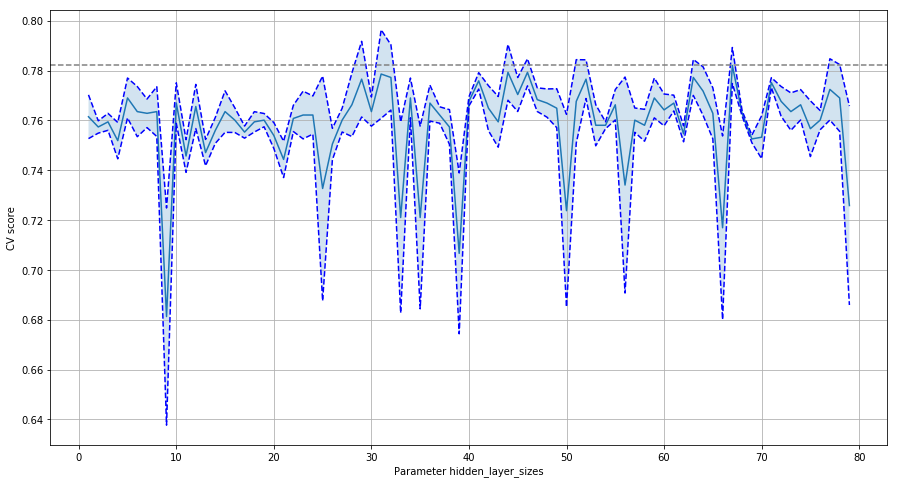

In [93]:
mlpc = MLPClassifier(solver='lbfgs')

parameter = "hidden_layer_sizes"
a = range(1,80)
alphas = [(2,i) for i in a]
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(mlpc, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, verbose=2)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']


alphas = a
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### hidden_layer_sizes 2

Fitting 3 folds for each of 79 candidates, totalling 237 fits
[CV] hidden_layer_sizes=(1, 30) ......................................
[CV] hidden_layer_sizes=(1, 30) ......................................
[CV] hidden_layer_sizes=(2, 30) ......................................
[CV] hidden_layer_sizes=(1, 30) ......................................
[CV] ....................... hidden_layer_sizes=(1, 30), total=   0.0s
[CV] hidden_layer_sizes=(2, 30) ......................................
[CV] ....................... hidden_layer_sizes=(1, 30), total=   0.0s
[CV] hidden_layer_sizes=(2, 30) ......................................
[CV] hidden_layer_sizes=(3, 30) ......................................
[CV] hidden_layer_sizes=(3, 30) ......................................
[CV] hidden_layer_sizes=(3, 30) ......................................
[CV] hidden_layer_sizes=(4, 30) ......................................
[CV] ....................... hidden_layer_sizes=(1, 30), total=   0.0s
[CV] hidden_lay

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.7s


[CV] ....................... hidden_layer_sizes=(5, 30), total=   5.6s
[CV] hidden_layer_sizes=(10, 30) .....................................
[CV] ....................... hidden_layer_sizes=(4, 30), total=   5.9s
[CV] hidden_layer_sizes=(11, 30) .....................................
[CV] ....................... hidden_layer_sizes=(3, 30), total=   6.1s
[CV] ....................... hidden_layer_sizes=(6, 30), total=   5.7s
[CV] hidden_layer_sizes=(13, 30) .....................................
[CV] hidden_layer_sizes=(14, 30) .....................................
[CV] ....................... hidden_layer_sizes=(7, 30), total=   5.6s
[CV] hidden_layer_sizes=(15, 30) .....................................
[CV] hidden_layer_sizes=(17, 30) .....................................
[CV] ....................... hidden_layer_sizes=(8, 30), total=   2.0s
[CV] ....................... hidden_layer_sizes=(5, 30), total=   6.2s
[CV] ....................... hidden_layer_sizes=(6, 30), total=   6.3s
[CV] h

[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:  2.2min finished


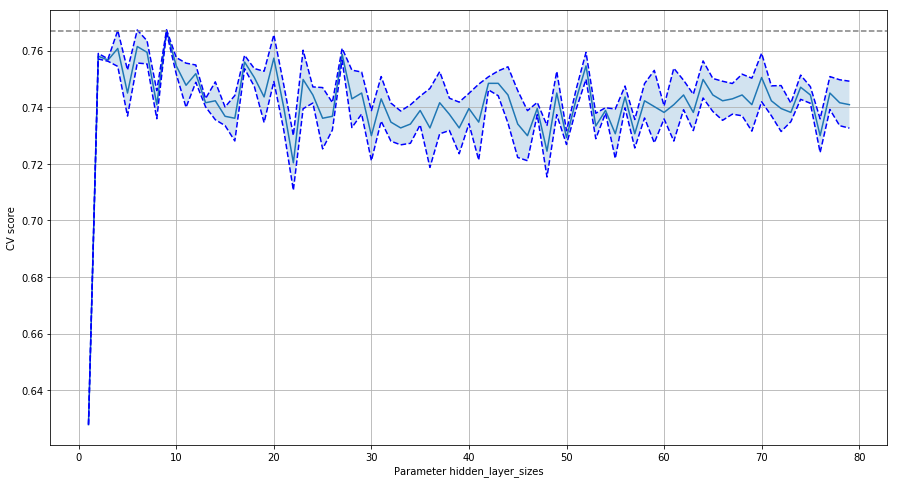

In [94]:
parameter = "hidden_layer_sizes"
a = range(1,80)
alphas = [(i,30) for i in a]
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(mlpc, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, verbose=2)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']


alphas = a
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

In [90]:
range(1,10,2)

[1, 3, 5, 7, 9]

In [58]:
help(mlpc)

Help on MLPClassifier in module sklearn.neural_network.multilayer_perceptron object:

class MLPClassifier(BaseMultilayerPerceptron, sklearn.base.ClassifierMixin)
 |  Multi-layer Perceptron classifier.
 |  
 |  This model optimizes the log-loss function using LBFGS or stochastic
 |  gradient descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity', 'logistic', 'tanh', 'relu'}, default 'relu'
 |      Activation function for the hidden layer.
 |  
 |      - 'identity', no-op activation, useful to implement linear bottleneck,
 |        returns f(x) = x
 |  
 |      - 'logistic', the logistic sigmoid function,
 |        returns f(x) = 1 / (1 + exp(-x)).
 |  
 |      - 'tanh', the hyperbolic tan function,
 |        returns f(x) = tanh(x).
 |  
 |      - 'relu', the rectified linear 

In [65]:
[(2,i) for i in range(1,100)]

[(2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 22),
 (2, 23),
 (2, 24),
 (2, 25),
 (2, 26),
 (2, 27),
 (2, 28),
 (2, 29),
 (2, 30),
 (2, 31),
 (2, 32),
 (2, 33),
 (2, 34),
 (2, 35),
 (2, 36),
 (2, 37),
 (2, 38),
 (2, 39),
 (2, 40),
 (2, 41),
 (2, 42),
 (2, 43),
 (2, 44),
 (2, 45),
 (2, 46),
 (2, 47),
 (2, 48),
 (2, 49),
 (2, 50),
 (2, 51),
 (2, 52),
 (2, 53),
 (2, 54),
 (2, 55),
 (2, 56),
 (2, 57),
 (2, 58),
 (2, 59),
 (2, 60),
 (2, 61),
 (2, 62),
 (2, 63),
 (2, 64),
 (2, 65),
 (2, 66),
 (2, 67),
 (2, 68),
 (2, 69),
 (2, 70),
 (2, 71),
 (2, 72),
 (2, 73),
 (2, 74),
 (2, 75),
 (2, 76),
 (2, 77),
 (2, 78),
 (2, 79),
 (2, 80),
 (2, 81),
 (2, 82),
 (2, 83),
 (2, 84),
 (2, 85),
 (2, 86),
 (2, 87),
 (2, 88),
 (2, 89),
 (2, 90),
 (2, 91),
 (2, 92),
 (2, 93),
 (2, 94),
 (2, 95),
 (2, 96),
 (2, 97),
 (2, 98),
 (2, 99)]